# Assignment 1.4: Negative sampling (15 points)

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling.

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o \cdot u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j \cdot u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution.

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [11]:
import numpy as np
import scipy.stats as sps
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook
from sklearn.metrics.pairwise import cosine_distances
import nltk
from collections import Counter
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
device = torch.device('cuda')
# device = torch.device('cpu')
torch.cuda.is_available()

True

In [0]:
# for SkipGram
# with negative samplihg
class BatcherNegative:
    def preprocess(self):
        self.tokens = nltk.word_tokenize(self.raw_text)
        del self.raw_text
        if self.data_percent is not None:
            self.tokens = self.tokens[:int(self.data_percent * len(self.tokens))]
        
        self.corpus_size = len(self.tokens)

        counter = Counter(self.tokens)
        counter = {k: v for k, v in sorted(counter.items(),
                                        key=lambda item: item[1],
                                        reverse=True)}

        most_frequent = list(counter)[:min(len(counter), self.vocab_size - 1)]
        
        self.word2Ind = {word : ind for ind, word in enumerate(most_frequent)}
        self.word2Ind[self.unknown] = len(self.word2Ind)
        self.ind2Word = {v : k for k, v in self.word2Ind.items()}

        most_frequent = set(most_frequent)
        self.tokens = np.array([self.word2Ind[token] if token in most_frequent 
                        else self.word2Ind[self.unknown]
                        for token in self.tokens])
        


        # обрезаем текст чтобы все батчи имели один шейп
        self.shuffle = np.arange(self.window_size, len(self.tokens)
        - self.window_size)
        np.random.shuffle(self.shuffle)

    # задаёт распределение на словах 
    def unigram(self):
        # слова с частотой встречаемости
        word_count = Counter(self.tokens)
        # не хотим семплировать UNK
        del word_count[self.unknown]
        x_values = list(word_count.keys())
        total_words = sum(word_count.values())
        word_prob = [(v / total_words) ** 3/4 for v in word_count.values()]
        word_prob_sum = sum(word_prob)
        word_prob = [p / word_prob_sum for p in word_prob]
        self.unigram_distribution = sps.rv_discrete(
            values=(x_values, word_prob))
        
    def negative_sample(self):
        return self.unigram_distribution.rvs(size=(self.batch_size,
                                                   self.num_negative))        
        


    def __init__(self, window_size=2, batch_size=100,
                data_path = 'text8', raw_text = None,
                vocab_size = 10000, data_percent = None,
                num_negative = 5):

        self.window_size = window_size
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.unknown = '<UNK>'
        self.data_percent = data_percent
        self.num_negative = num_negative


        if raw_text is None:
            self.raw_text = open(data_path).read()
        else:
            self.raw_text = raw_text

        self.preprocess()
        self.unigram()

        self.ind = 0 

    def __iter__(self):
        return self
    

    def __next__(self):
        # если последний батч вылезает за границы корпуса, просто пропускаем его
        if self.ind + self.batch_size >= len(self.shuffle):
            raise StopIteration

        centers_pos = self.shuffle[self.ind:self.ind + self.batch_size]

        windows = [list(self.tokens[c - self.window_size:c]) + 
                    list(self.tokens[c + 1: c + self.window_size + 1])
                                        for c in centers_pos]

        self.ind += self.batch_size
        return self.tokens[centers_pos], np.array(windows), self.negative_sample()

    # вернуть итератор к началу текста
    def reset(self):
        np.random.shuffle(self.shuffle)
        self.ind = 0
    

In [0]:
# with negative sampling
class SkipGramNegative:
    def __init__(self, window_size=2, batch_size=10, vocab_size=10000,
                 embed_dim=100, learning_rate = 1e-4, num_negative=5):
        self.window_size = window_size
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.learning_rate = learning_rate
        self.num_negative = num_negative
        self.unknown = '<UNK>'

        self.model = torch.nn.Sequential(
            torch.nn.Embedding(vocab_size, embed_dim),
            torch.nn.Linear(embed_dim, vocab_size, bias=False))
        self.model = self.model.to(device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def fit(self, batcher, num_iter=1):
        self.word2Ind = batcher.word2Ind
        self.ind2Word = batcher.ind2Word
        loss_fn = torch.nn.LogSigmoid()
        self.loss_history = []
        start = time.time()

        for k in tqdm_notebook(range(num_iter)):
            num_batch = 0
            print(f'---Epoch: {k}---')
            for batch in tqdm_notebook(batcher):
                score = self.model(torch.from_numpy(batch[0]).to(device, dtype=torch.long))
                # score.shape = (batch, vocab)
                # batch[1].shape = (batch, 2*window_size)
                # batch[2].shape = (batch, num_negative)
                # индексы строк, из которых надо взять элементы
                positive_row_ind = sum(
                    [[i] * (2 * self.window_size) 
                    for i in range(self.batch_size)], [])
                
                # score от положительных примеров(из окна)
                positive = score[positive_row_ind, batch[1].flatten()]
                negative_row_ind = sum(
                    [[i] * (self.num_negative) 
                    for i in range(self.batch_size)], [])
                 
                 # score от отрицательных примеров(случайно сгенерированных)
                negative = score[negative_row_ind, batch[2].flatten()]

                # усреднение лосса по батчу
                loss = (-loss_fn(positive)).sum() - loss_fn(-negative).sum() / self.batch_size
                 
                num_batch += 1
                
                if num_batch % 100 == 0:
                    now = time.time()
                    print(f'Batch number: {num_batch}\t loss: {loss} \t time elapsed: {round(now - start)}')

                if num_batch % 100 == 0:
                    self.loss_history.append(loss)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            batcher.reset()
            
            
        
    def build_word2vec(self):
        u, v = list(self.model.parameters())
        vecs = (u + v) / 2
        self.w2v_dict = {self.ind2Word[ind] : vecs[ind].detach().cpu().numpy() for ind in self.ind2Word.keys()}
        self.v2w_dict = {tuple(v): k for k, v in self.w2v_dict.items()}

    def word2vec(self, words):
        return [self.w2v_dict[word] if word in self.w2v_dict 
                else self.w2v_dict[self.unknown] for word in words]
    
    def vec2word(self, vectors):
        return [self.v2w_dict[tuple(vector)] if tuple(vector) in self.v2w_dict
                else self.unknown for vector in vectors]
        
    def top_10_cosine_closest(self, vector):
        all_vectors = np.array(list(self.w2v_dict.values()))
        distances = cosine_distances(vector.reshape(1, -1), all_vectors)
        sort_ind = np.argsort(distances.flatten())
        return all_vectors[sort_ind][:10]
        
    # positive1 + positive2 - negative = ...
    def analogy(self, positive1, negative, positive2):
        pos1_vec, pos2_vec, neg_vec = self.word2vec((positive1, positive2, negative))
        result_vec = pos1_vec - neg_vec + pos2_vec
        closest_vec = self.top_10_cosine_closest(result_vec)
        # исключаем сами положительные слова
        closest_vec = [v for v in closest_vec if (np.any(v != pos1_vec) and np.any(v != pos2_vec))]

        return self.v2w_dict[tuple(closest_vec[0])]

In [36]:
text_test = ' '.join(['first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'class', 'working'])
batcher_test = BatcherNegative(raw_text=text_test, batch_size=1, num_negative=3)
batcher_test.unigram()
batcher_test.negative_sample()
for batch in batcher_test:
    print(batch)
batcher_test.reset()
model_test = SkipGramNegative(embed_dim = 2, batch_size=1, num_negative=3)
model_test.fit(batcher_test)

(array([0]), array([[4, 5, 1, 6]]), array([[0, 1, 0]]))
(array([5]), array([[3, 4, 0, 1]]), array([[0, 0, 0]]))
(array([1]), array([[5, 0, 6, 7]]), array([[6, 0, 0]]))
(array([7]), array([[1, 6, 1, 0]]), array([[1, 1, 0]]))
(array([6]), array([[0, 1, 7, 1]]), array([[1, 1, 1]]))


---Epoch: 0---


In [0]:
# del model_test
torch.cuda.empty_cache()

In [0]:
batch_size = 1024
window_size = 4
vocab_size = 20000
data_percent = 1
num_negative= 5
data_path = '/content/drive/My Drive/Colab Notebooks/text8'
batcher = BatcherNegative(batch_size=batch_size, window_size=window_size,
                  data_percent=data_percent, vocab_size = vocab_size,
                  data_path=data_path, num_negative=num_negative)

In [0]:
learning_rate = 3e-3
embed_dim = 300
model = SkipGramNegative(window_size=window_size, batch_size=batch_size,
                 embed_dim=embed_dim, vocab_size=vocab_size,
                 learning_rate=learning_rate, num_negative=num_negative)

In [0]:
model.fit(batcher, num_iter=5)

---Epoch: 0---


Batch number: 100	 loss: 2442.39501953125 	 time elapsed: 7
Batch number: 200	 loss: 1190.757568359375 	 time elapsed: 14
Batch number: 300	 loss: 888.4411010742188 	 time elapsed: 20
Batch number: 400	 loss: 611.4489135742188 	 time elapsed: 27
Batch number: 500	 loss: 452.65679931640625 	 time elapsed: 34
Batch number: 600	 loss: 347.0634460449219 	 time elapsed: 40
Batch number: 700	 loss: 282.38775634765625 	 time elapsed: 47
Batch number: 800	 loss: 201.25807189941406 	 time elapsed: 54
Batch number: 900	 loss: 197.9112091064453 	 time elapsed: 60
Batch number: 1000	 loss: 118.03958892822266 	 time elapsed: 67
Batch number: 1100	 loss: 107.86625671386719 	 time elapsed: 74
Batch number: 1200	 loss: 117.95648193359375 	 time elapsed: 81
Batch number: 1300	 loss: 102.37686157226562 	 time elapsed: 87
Batch number: 1400	 loss: 105.83158111572266 	 time elapsed: 94


In [0]:
torch.save(model, '/content/drive/My Drive/Colab Notebooks/word2vec_negative.pt')

Далее проверим качество модели при помощи методов из предыдущего ноутбука.

In [7]:
sns.set(style='darkgrid')
plt.figure(figsize = (15, 8))
plt.plot(10 * np.arange(len(model.loss_history)), model.loss_history)
# plt.ylim((0, 100))
plt.xlabel('количество батчей')
plt.ylabel('loss')
plt.title('Зависимость функции потерь от количества батчей')
plt.show()

NameError: ignored

<Figure size 1080x576 with 0 Axes>

In [0]:
test_words = ['football', 'basketball', 'baseball',
              'physics', 'math', 'chemistry', 'biology', 'philosophy',
              'head', 'body', 'hand', 'arm', 'leg', 'foot',
              'he', 'she', 'it', 'i', 'you', 'they',
             ]

# test_words = set([batcher.ind2Word[token] for token in batcher.tokens[:100]])

model.build_word2vec()
word_vectors = model.word2vec(test_words)

In [0]:
# umap показался лучше, чем предложенные в задании библиотеки
import umap
reducer = umap.UMAP()
word_vectors_embedded = reducer.fit_transform(word_vectors)

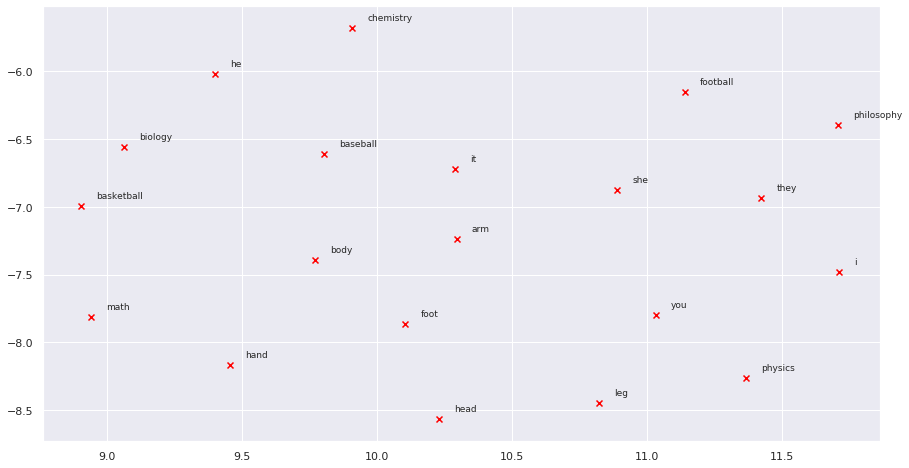

In [19]:
plt.figure(figsize=(15, 8))

x_coords = word_vectors_embedded[:, 0]
y_coords = word_vectors_embedded[:, 1]
 
x_text_shift = (np.max(x_coords) - np.min(x_coords)) / 50
y_text_shift = (np.max(y_coords) - np.min(y_coords)) / 50

for i, word in enumerate(test_words):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+x_text_shift, y+y_text_shift, word, fontsize=9)

plt.show()

In [0]:
intr_test_file = open('word_similarity_test.txt.txt')
intr_text = intr_test_file.read().lower()
intr_test_cases = intr_text.split(':')[1:]
intr_results = {}
for test_case in tqdm_notebook(intr_test_cases):
    lines = test_case.split('\n')
    name = lines[0]
    true_analogies = [line.split()[3] for line in lines[1:-1]]
    answers = []
    for line in tqdm_notebook(lines[1:-1]):
        answer = model.analogy(*line.split()[:3])
        answers.append(answer)
        
        
    total_analogies = len(true_analogies)
    
    correct_guesses = np.sum([pair[0] == pair[1] for pair in zip(answers, true_analogies)])
    print(name, correct_guesses, total_analogies)
